In [1]:
# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

In [2]:
# Loading the dataset and pre-processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=True, download=False, transform=transform),
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=False, transform=transform),
    batch_size=64,
    shuffle=False,
    num_workers=2
)

# Custom Convolutional Neural Network

In [3]:
class CustomCNN(nn.Module):
    def __init__(self, chanels, kernel_size):
        super(CustomCNN, self).__init__()
        
        # First block
        self.conv1 = nn.Conv2d(1, chanels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(chanels)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        # Second block
        self.conv2 = nn.Conv2d(chanels, 2 * chanels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(2 * chanels)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        # Third block
        self.conv3 = nn.Conv2d(2*chanels, 4 * chanels, kernel_size, padding=kernel_size//2)
        self.bn3 = nn.BatchNorm2d(4 * chanels)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        
        # Fourth block (no pooling after this)
        self.conv4 = nn.Conv2d(4*chanels, 8 * chanels, kernel_size, padding=kernel_size//2)
        self.bn4 = nn.BatchNorm2d(8 * chanels)
        self.relu4 = nn.ReLU()
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(8*chanels, 128)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.relu4(self.bn4(self.conv4(x)))
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = self.drop1(F.relu(self.fc1(x)))
        x = self.fc2(x) 
        
        return x

In [4]:
# Placeholders for metrics
train_losses = []
test_losses = []
test_accuracies = []

In [5]:
# Loss Function and Optimizer
model = CustomCNN(chanels=32, kernel_size=3).cuda()  # .cuda() if using GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):

    model.train() 
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()  # .cuda() if using GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:  # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    
    # Calculate training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validate the model
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Test Loss: {avg_test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%')

[1,   200] loss: 0.402
[1,   400] loss: 0.099
[1,   600] loss: 0.086
[1,   800] loss: 0.070
Epoch [1/5] Train Loss: 0.0104 Test Loss: 0.0426 Test Accuracy: 98.65%
[2,   200] loss: 0.045
[2,   400] loss: 0.053
[2,   600] loss: 0.049
[2,   800] loss: 0.046
Epoch [2/5] Train Loss: 0.0074 Test Loss: 0.0308 Test Accuracy: 99.04%
[3,   200] loss: 0.033
[3,   400] loss: 0.039
[3,   600] loss: 0.036
[3,   800] loss: 0.035
Epoch [3/5] Train Loss: 0.0059 Test Loss: 0.0234 Test Accuracy: 99.22%
[4,   200] loss: 0.031
[4,   400] loss: 0.028
[4,   600] loss: 0.031
[4,   800] loss: 0.030
Epoch [4/5] Train Loss: 0.0049 Test Loss: 0.0312 Test Accuracy: 99.06%
[5,   200] loss: 0.022
[5,   400] loss: 0.023
[5,   600] loss: 0.027
[5,   800] loss: 0.027
Epoch [5/5] Train Loss: 0.0042 Test Loss: 0.0250 Test Accuracy: 99.24%


In [6]:
# Saving model
torch.save(model.state_dict(), './Models/custom_cnn_mnist.pth')

/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/fonta42/anaconda3/envs/torchtrainer/li

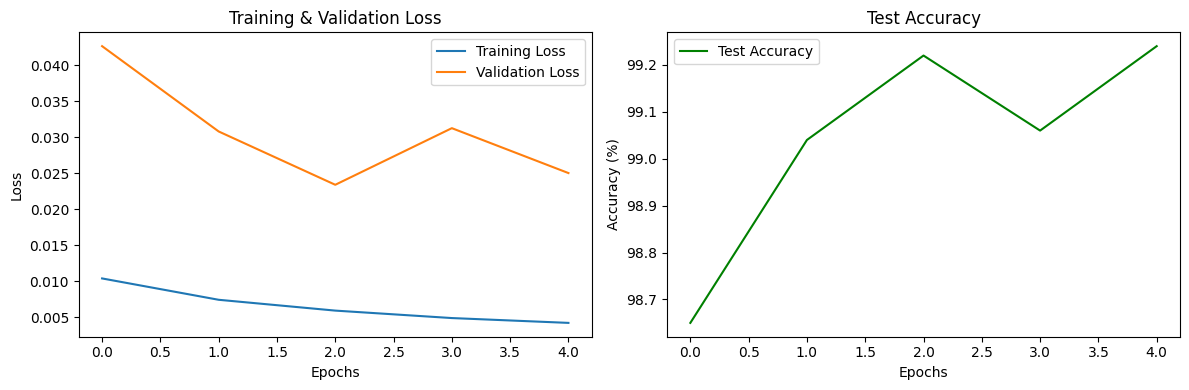

In [7]:
# 4. Plotting metrics
plt.figure(figsize=(12, 4))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
_ = plt.legend()

# Test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
_ = plt.legend()

_ = plt.tight_layout()
_ = plt.show()

In [8]:
# Optional: Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()  # .cuda() if using GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 99 %
